In [242]:
# import Python data analysis and plotting tools
import numpy as np; import pandas as pd
from pandas import DataFrame, Series
import matplotlib
import matplotlib.pyplot as plt
import random
import json
# mapping functionality
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [243]:
# Read data on trips made in 2013 from csv
location_data = pd.read_csv('Divvy_Stations_Trips_2013/Divvy_Stations_2013.csv', dtype='unicode')
trip_data = pd.read_csv('Divvy_Stations_Trips_2013/Divvy_Trips_2013.csv', dtype='unicode')
location_data[['id']] = location_data[['id']].astype(int)
location_data = location_data.set_index("id")
trip_data = trip_data.set_index("trip_id")

In [244]:
# Coordinates of landmarks to be included on map for geographical context
landmarks = ['University of Chicago', 'Millennium Park', 'Willis Tower', 'Wrigley Field', 'Field Museum']
lats = [41.7897, 41.8827, 41.8789, 41.9483, 41.8663]
longs = [-87.5997, -87.6227, -87.6358, -87.6556, -87.6170]

In [245]:
# Drop some superfluous columns
trip_data.drop(['gender', 'birthday'],inplace=True,axis=1)
# Make sure numeric fields are seen as correct data types
trip_data[['bikeid', 'tripduration', 'from_station_id', 'to_station_id']] = trip_data[['bikeid', 'tripduration', 'from_station_id', 'to_station_id']].astype(int)
location_data[['longitude', 'latitude']] = location_data[['longitude', 'latitude']].astype(float)

In [246]:
# Build a dataframe of trips, grouped by originating and terminal station id, 
# the number of trips of to/from those stations, and the average length of those trips
trip_summary = trip_data[['from_station_id', 'to_station_id', 'tripduration']]
trip_summary = trip_summary.groupby(['from_station_id', 'to_station_id'])['tripduration'].agg({'number_trips': len, 'avg_duration': np.mean})

In [247]:
# Count the number of trips to and from each station
trips_from = DataFrame(trip_data.groupby('from_station_id').size())
trips_to = DataFrame(trip_data.groupby('to_station_id').size())

In [248]:
trips_from.index.names = ['station_id']
trips_to.index.names = ['station_id']
trips_from.columns = ['number_trips_from']
trips_to.columns = ['number_trips_to']
trip_counts = trips_to.join(trips_from)

In [249]:
# Calculate the difference in number of trips starting vs ending at a station
trip_counts['diff'] = trip_counts['number_trips_to'] - trip_counts['number_trips_from']

In [250]:
# Join this with the table of latitudes and longitudes so that it can be plotted on a map
trip_counts = trip_counts.join(location_data[['latitude','longitude']])

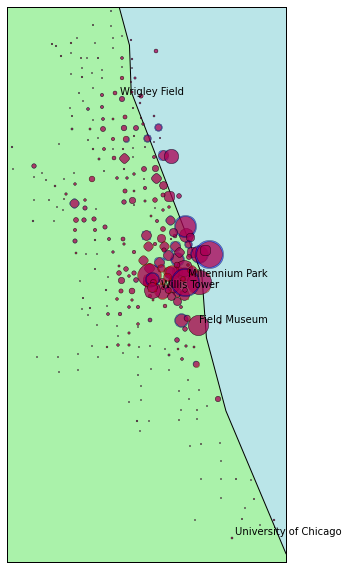

In [251]:
# Make a figure of the most used stations (size of dot represents # of trips to/from that station)
# Size of red dot represents volume of trips from that station
# Size of blue dot represents volume of trips to that station
fig = plt.figure()
fig.set_size_inches(5,10)
# Map of the city of Chicago
map = Basemap(projection='merc', lat_0=41.8, lon_0=-87.5,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=-87.71, llcrnrlat=41.78,
    urcrnrlon=-87.575, urcrnrlat=41.98)
map.drawcoastlines()
map.drawcountries()
# Color it in
map.fillcontinents(color='#AAF2AA', lake_color="#BAE5E8")
for ix, row in trip_counts.iterrows():
    # scale so the resulting dots aren't too huge
    to_dotsize = row['number_trips_to']/650
    from_dotsize = row['number_trips_from']/650
    # make each dot at least a pixel
    if to_dotsize < 1:
        to_dotsize = 1
    if from_dotsize < 1:
        from_dotsize = 1
    x, y = map(row['longitude'], row['latitude'])
    map.plot(x, y, 'bo', alpha = 0.5, markersize=to_dotsize)
    map.plot(x, y, 'ro', alpha = 0.5, markersize=from_dotsize)
for i in range(0, len(landmarks)):
    x, y = map(longs[i],lats[i])
    plt.text(x,y, landmarks[i])
plt.savefig("mostused.png")

In [252]:
plt.close(fig)

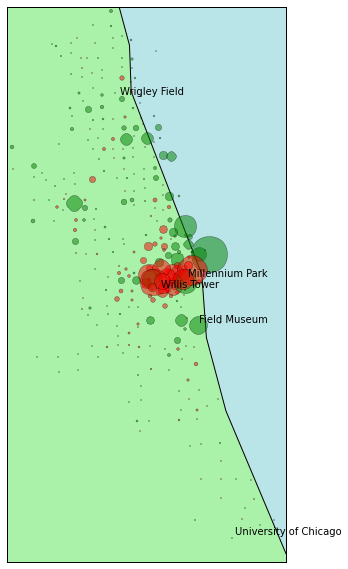

In [253]:
# This graph is meant to visualize how much of a "sink" or "source" each station is
# Green dots mean there are more trips to that station than from it
# Red dots mean the reverse
# The size of the dot represents the size of the difference
fig = plt.figure()
fig.set_size_inches(5,10)
# Do the same mapping as before
map = Basemap(projection='merc', lat_0=41.8, lon_0=-87.5,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=-87.71, llcrnrlat=41.78,
    urcrnrlon=-87.575, urcrnrlat=41.98)
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color='#AAF2AA', lake_color="#BAE5E8") 
# Draw each dot based on the data
for ix, row in trip_counts.iterrows():
    dotsize = abs(row['diff'])/50
    if dotsize < 1:
        dotsize = 1
    if row['diff'] > 0:
        color = 'go'
    else:
        color = 'ro'
    x, y = map(row['longitude'], row['latitude'])
    map.plot(x, y, color, alpha=0.5, markersize=dotsize)
# Fill in the landmark names
for i in range(0, len(landmarks)):
    x, y = map(longs[i],lats[i])
    plt.text(x,y, landmarks[i])
plt.savefig("diffs.png")

In [254]:
plt.close(fig)

In [255]:
top_trips = trip_summary.sort(['number_trips'], ascending=False)

In [256]:
top_trips = top_trips.head(100)

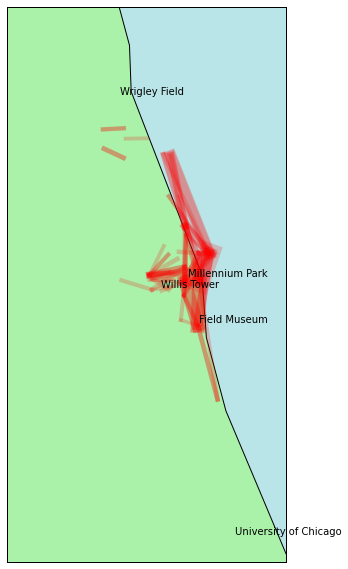

In [257]:
# Plot the most common trips on a map, with line thickness corresponding to the volume of trips between
# those two stations
fig = plt.figure()
fig.set_size_inches(5,10)
# The usual mapping stuff
map = Basemap(projection='merc', lat_0=41.8, lon_0=-87.5,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=-87.71, llcrnrlat=41.78,
    urcrnrlon=-87.575, urcrnrlat=41.98)
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color='#AAF2AA', lake_color="#BAE5E8")
# Draw each line
for ix, row in top_trips.iterrows():
    # Scale each line so they don't get too thivk
    width = row['number_trips']/100
    startlat = location_data['latitude'][ix[0]]
    startlong = location_data['longitude'][ix[0]]
    endlat = location_data['latitude'][ix[1]]
    endlong = location_data['longitude'][ix[1]]
    map.drawgreatcircle(startlong,startlat,endlong,endlat, alpha=0.2, linewidth=width,color='red')
for i in range(0, len(landmarks)):
    x, y = map(longs[i],lats[i])
    plt.text(x,y, landmarks[i])
plt.savefig("trips.png")

In [258]:
plt.close(fig)

In [267]:
# export top trips to a CSV to fetch transit and biking time from the Google Maps API
top_trips.to_csv('toptrips.csv', encoding='utf-8')
# import cleaned-up Google maps data containing travel times
travel_times = pd.read_csv('trip_output.csv', sep=';')
travel_times = travel_times.set_index("Unnamed: 0")
travel_times.index.names = ['id']

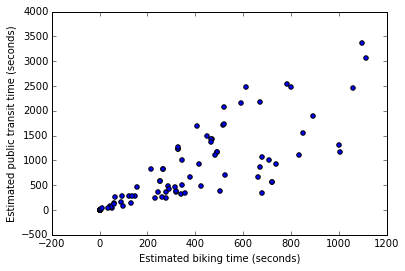

In [268]:
plt.xlabel('Estimated biking time (seconds)')
plt.ylabel('Estimated public transit time (seconds)')
plt.scatter(travel_times['biking_time'],travel_times['transit_time'])
plt.savefig("bike_vs_transit.png")

In [269]:
plt.close()

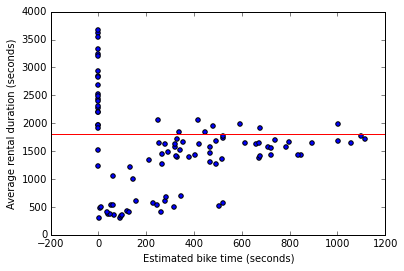

In [270]:
plt.scatter(travel_times['biking_time'], travel_times['avg_duration'])
plt.xlabel('Estimated bike time (seconds)')
plt.ylabel('Average rental duration (seconds)')
plt.axhline(y = 1800, color='red')
plt.savefig("bike_vs_actual.png")

In [271]:
plt.close()

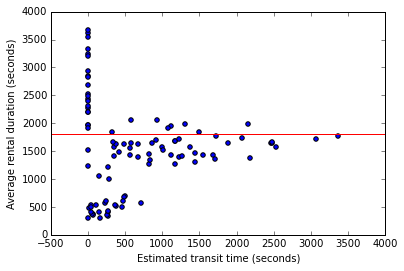

In [272]:
plt.scatter(travel_times['transit_time'],travel_times['avg_duration'])
plt.xlabel('Estimated transit time (seconds)')
plt.ylabel('Average rental duration (seconds)')
plt.axhline(y = 1800, color='red')
plt.savefig("transit_vs_actual.png")

In [273]:
plt.close()